## Relevance Feedback

The significant part of any Information retrieval system is to make it responsive to user interaction. <br>
Hence our system needs to incorporate the feedback and refine the results adapted to the user input on the fly.<br>
Few of the use-cases would be, search engines like Google, Bing and other websites like Youtube <br> which personalize the content for a better user experience.


In this experiment we would implement two algorithms for achieving adaptive retrieval based on user input.<br>
#### Dataset - Wikipedia documents, a total of 2866 ranging over 10 different categories.

1. #### Weighted KNN 
    - Random list of wikipedia documents (varied category) are displayed to the User. 
    - The user based on his interest clicks on any document belonging to a particular category. 
    - We implement a weighted KNN to get a ranking of the relevant documents based on the user input.
    - The user then again clicks a document of the relevant documents.
    - We update the weight vector based on this feedback to get a new ranking which ensures better recall than before

2. #### Rocchio Algorithm
    - Random list of documents are displayed.
    - The user clicks on a particular document and also decides the relevant and non relevant documents of the displayed ones.
    - The initial document clicked is our Query $q$ (initial centroid for relevant documents). <br> Relevant Documents are $D_{r}$, Non relevant ones are $D_{nr}$.
    - We use the following formula to converge to a new centroid for the relevant documents.<br> This ensures better precision with every iteration
    
    $$q_{t+1} = a . q_{t} + b. (\frac{1}{|D_{r}|} \sum_{d_{j} \in D_{r}} d_{j}) - c. (\frac{1}{|D_{nr}|} \sum_{d_{k} \in D_{nr}} d_{k})$$
    
    - Display the nearest neighbours of the new centroid $q_{t+1}$, which would be more relevant

In [0]:
# The below are wrapper functions used to connect to your drive and this needs to be run once (i.e. once every new session or possibily refreshes for every 24 hours)

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Authentication for your google drive
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

# Authentication for the wrapper libraries  or possibily refreshes for every 24 hours)

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


gpg: keybox '/tmp/tmp_ickdzos/pubring.gpg' created
gpg: /tmp/tmp_ickdzos/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
gpg: keybox '/tmp/tmp5t4t7_94/pubring.gpg' created
gpg: /tmp/tmp5t4t7_94/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
%cd MyDrive

/content/MyDrive


In [0]:
%cd Session14

/content/MyDrive/Session14


In [0]:
!ls

Experiment2_A.ipynb  Experiment2_B.ipynb  picture.png  wikipedia_dataset


In [0]:
from lxml import etree
from glob import glob
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
import numpy as np
import random
from bs4 import BeautifulSoup as Soup
from collections import Counter
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import os
from IPython.display import clear_output
from IPython.display import display, HTML
import matplotlib.pyplot as plt

## Dataset Description ##


1. The dataset comprises 2866 Wikipedia articles belonging to a total of 10 categories.
2. Each of the article is given a query ID based on it's category.

In [0]:
f = open('wikipedia_dataset/categories.list')
cats = f.readlines()
f = open('wikipedia_dataset/categories_originalids.list')
cat = f.readlines()
print('The following ' + str(len(cats)) + ' categories', cats)

The following 10 categories ['art\n', 'biology\n', 'geography\n', 'history\n', 'literature\n', 'media\n', 'music\n', 'royalty\n', 'sport\n', 'warfare\n']


## Parsing the XML data files 

In [0]:
def parseLog(file, docs, qid):
    handler = open(file).read()
    soup = Soup(handler,'lxml')
    #print(soup.findAll('text')[0])
    txt = soup.findAll('text')[0].text       
    for message in soup.findAll('document'):
        msg_attrs = dict(message.attrs)
        qid.append(int(msg_attrs['cat']))
        docs .append(msg_attrs['name'] + ' ' + txt)

lis = glob('wikipedia_dataset/texts/*')
docs = []
qid = []
for i in range(len(lis)):
    parseLog(lis[i], docs, qid)


In [0]:
print('Sample document:', qid[100], docs[100][:100] + '...')

Sample document: 11 Seattle 
Qwest Field, home of the Seattle Seahawks and Seattle Sounders FC


Seattle's professional ...


## Construct feature vector from documents

In [0]:
stoplist = open('wikipedia_dataset/stopwords.txt').read().splitlines()

In [0]:
## TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words=stoplist, min_df=0.001)
matrix = vectorizer.fit_transform(docs)
doc_vectors = matrix.todense()
doc_vectors = np.array(doc_vectors)
vocab = vectorizer.vocabulary_

### Read about min_df parameter used above.
Vary the parameter to change the feature and see it's effect on the final results.

In [0]:
print('Length of the vocabulary:', len(vocab))
print('A sample ' +str(len(vocab)) +' dimensional document vector:', doc_vectors[1][:100])

Length of the vocabulary: 27228
A sample 27228 dimensional document vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [0]:
print(doc_vectors.shape, len(qid))

(495, 27228) 495


### 1. Weighted KNN 
- Initially display random 20 documents and get user click
- Run the KNN Algorithm and chose 100 nearest neighbours
- Define a weight matrix to get the ranking of the 100 relavent vectors based on similarity

Given $m$ - dimensional query $q$ and document $d_{i}$, the weighted similarity is calculated as follows <br> 
$q = (q_{1}, q_{2}, \cdots, q_{m})$ <br>
$d_{i} = (d_{1}, d_{2}, \cdots, c_{m})$ <br>
$$Similarity = w^T d'_{i}$$ where ,
$$d'_{i} = \frac{q * d_{i}}{\parallel q \parallel \parallel d_{i} \parallel}  $$

In [0]:
## Fit KNN
KNN = NearestNeighbors(100, 0.4, metric = 'cosine')
KNN.fit(doc_vectors)
neighbours = KNN.kneighbors(doc_vectors,return_distance=False)
print(neighbours.shape)

(495, 100)


In [0]:
# Number of articles displayed at max 100
num = 10
div = 1 # Change the value to see the effect

,index,Article,category
0,166,Walter_Model \nModel's success in holding his ...,Warfare
1,112,Honoré_de_Balzac \nBalzac's first project was ...,Literature and theatre
2,37,"Italian_War_of_1542–1546 \nThe Truce of Nice, ...",Warfare
3,116,History_of_the_National_Hockey_League_(1917–19...,Sport and recreation
4,340,"USS_Nevada_(BB-36) \nAfter D-Day, the Allies h...",Warfare
5,109,USS_Nevada_(BB-36) \nAfter fitting out in the ...,Warfare
6,329,Sasha_(DJ) \nInfluenced by the early sound of ...,Music
7,469,"Lazare_Ponticelli \nUntil his death, Ponticell...",Warfare
8,476,Henry_James \nAlthough any selection of James'...,Literature and theatre
9,157,Sicilian_Baroque \nThe great Sicilian earthqua...,"Art, architecture and archaeology"


Select the index of the article you would like to read or type 'stop' if you want end the searchstop
Enjoy your Article


Text(0,0.5,'Score given by you')

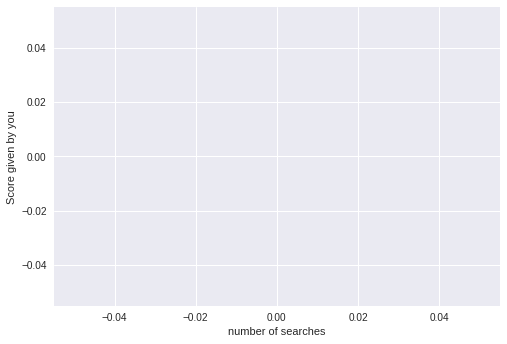

In [0]:
def to_display(doc_ids, init= False):
    if init == True:
        ix = random.sample(range(0, len(doc_vectors)), num)
    else:
        ix = doc_ids
    
    df = pd.DataFrame(columns=['index', 'Article','category'])
    df['index'] = ix
    df['Article'] = [docs[i][:100] for i in ix]
    df['category'] = [cat[qid[i]-1][:-1] for i in ix] 
    clear_output()
    display(HTML(df.to_html()))
    return ix

def get_user_choice(q):
    doc_id = random.choice(q)
    return doc_id

index = to_display([],init= True)
doc_id = input("Select the index of the article you would like to read or type 'stop' if you want end the search")
doc_id = int(doc_id)
res = []
ctr = 0
## initialize the weight vector to ones
weights = np.ones((doc_vectors.shape[1],1))
while (True):   
    query_doc = doc_vectors[doc_id].reshape(1, doc_vectors.shape[1])
    relevant_docs_ix = neighbours[doc_id]
    relevant_docs = doc_vectors[relevant_docs_ix]
    ## Calculate Similarity
    new_relevance = (query_doc[0] * relevant_docs) / (np.linalg.norm(relevant_docs) * np.linalg.norm(query_doc) )
    similarity  = np.matmul(new_relevance , weights)
    ## Return the num most ranked doc ids
    ranked_docs_ix = relevant_docs_ix[np.argsort(similarity[:,0])]
    index = to_display(ranked_docs_ix[:num])
    doc_id = input("Select the index of the article you would like to read or type 'stop' if you want end the search")
    if doc_id == 'stop':
        break    
    doc_id = int(doc_id)
    weights = weights + doc_vectors[doc_id].reshape(doc_vectors.shape[1], 1)
    weights = weights/ np.linalg.norm(weights)
    ctr += 1
    res_ = input("Give the precision count/a number between 1-10 about how satisfied are you with the results")
    res.append(res_)
print('Enjoy your Article')

plt.plot(res)
plt.xlabel("number of searches")
plt.ylabel("Score given by you")

### 2. Rocchio Algorithm
- Initially random articles are displayed
- Select an index value based on your choice
- Select all the indices of relevant documents
- Update the centroid of relavant vector as shown in the formula above
- Display the nearest neighbours of the relavant vector

- $alpha$- how close to relavant 
- $beta$ - how far from non relevant

Ideally we would like to have high $alpha$ and low $beta$

In [0]:
alpha = 1.0
beta = 0.5
index = to_display([],init= True)
while(True):
    doc_id = input("Select the index of the article you would like to read or type 'stop' if you want end the search")
    if doc_id == 'stop':
        break
    print("Enter the indices, comma separated for relevant documents")
    R = [int(x) for x in input().split(',')]
    NR = [i for i in index if i not in R]
    doc_id = int(doc_id)
    query_doc = doc_vectors[doc_id].reshape(1, doc_vectors.shape[1])
    R_docs = doc_vectors[R]
    NR_docs = doc_vectors[NR]

    q_new = query_doc + (alpha * np.sum(R_docs, 0)/len(R)) - (beta * np.sum(NR_docs, 0)/len(NR))
    print(q_new.shape)
    retrieved = KNN.kneighbors(q_new, return_distance=False)
    index = to_display(retrieved[0][:num])
    
print('Enjoy your article')

,index,Article,category
0,369,George_III_of_the_United_Kingdom \nGeorge III ...,"Royalty, nobility and heraldry"
1,179,André_Kertész \nKertész emigrated to Paris in ...,"Art, architecture and archaeology"
2,345,George_V_of_the_United_Kingdom \nOn 24 May 189...,"Royalty, nobility and heraldry"
3,149,George_VI_of_the_United_Kingdom \nAlbert assum...,"Royalty, nobility and heraldry"
4,470,Monarchy_of_the_United_Kingdom \nFollowing Vik...,"Royalty, nobility and heraldry"
5,265,Prince's_Palace_of_Monaco \nPrince Rainier III...,"Art, architecture and archaeology"
6,431,Wonder_Stories \nThe editorial duties at ''Won...,Literature and theatre
7,48,Alexandra_of_Denmark \nShe did not attend her ...,"Royalty, nobility and heraldry"
8,74,"Pierre_Rossier \nIn 1861, Rossier was in Siam,...","Art, architecture and archaeology"
9,81,Roman_Vishniac \nVishniac is best known for hi...,"Art, architecture and archaeology"


Select the index of the article you would like to read or type 'stop' if you want end the searchstop
Enjoy your article
